In [1]:
import json
import requests
import collections 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import statsmodels as sms
import statsmodels.stats.multitest as smt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Section 1: Data Wrangling

In [2]:
#NEW
with open('much_lol_data.json', 'r') as file:
   newdata = json.load(file)

With the JSON file loaded, I immediately turned it into a dataframe and checked its dimensions.

In [3]:
#NEW
newdf = pd.DataFrame(newdata)
newdf.shape

(1274, 13)

In [4]:
#NEW
newdf.head()

,gameCreation,gameDuration,gameId,gameMode,gameType,gameVersion,mapId,participantIdentities,participants,platformId,queueId,seasonId,teams
0,1547596951223,2045,2953655077,CLASSIC,MATCHED_GAME,9.1.257.7563,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T..."
1,1547535028615,973,2953405899,CLASSIC,MATCHED_GAME,9.1.257.7563,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T..."
2,1547532226325,2340,2953398465,CLASSIC,MATCHED_GAME,9.1.257.7563,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T..."
3,1547529414046,2005,2953370371,CLASSIC,MATCHED_GAME,9.1.257.7563,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ..."
4,1547518323960,1296,2953217441,CLASSIC,MATCHED_GAME,9.1.257.7563,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,420,11,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ..."


The columns that I care about here are 'gameMode' and 'participantidentities'. League of Legends has a few game modes, but we are interested in the CLASSIC mode, which is the most popular and competitive mode. Each row can be thought of as a game that occurred. 

In [5]:
#NEW
newgames = newdf[['participants','gameMode']]
newgames.head()

,participants,gameMode
0,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
1,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
2,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
3,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
4,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC


In [6]:
# We only want games on the Summoner's Rift map (CLASSIC) 
newclassicgames = newgames[newgames['gameMode'] == 'CLASSIC']['participants']
newclassicgames.head()

0    [{'participantId': 1, 'teamId': 100, 'champion...
1    [{'participantId': 1, 'teamId': 100, 'champion...
2    [{'participantId': 1, 'teamId': 100, 'champion...
3    [{'participantId': 1, 'teamId': 100, 'champion...
4    [{'participantId': 1, 'teamId': 100, 'champion...
Name: participants, dtype: object

Above is an example of all the stats and data have from one game (row). There are five players on each of two teams, making a total of 10 players (10 'participantIds"). Like newclassicgames[1], each game is simply a list of 10 dictionaries, one dictionary per player. 

In [ ]:
newclassicgames[1]

In [8]:
# NEW
newgames.head()

,participants,gameMode
0,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
1,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
2,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
3,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC
4,"[{'participantId': 1, 'teamId': 100, 'champion...",CLASSIC


Below, I created a function that takes in a game, and converts the list of dictionaries into a Pandas row, or a dataframe object.   

In [9]:
# Below is a list of keys that I want to keep
stats_keep_columns = ['participantId','win','item0','item1','item2','item3','item4','item5',
'item6','kills','deaths','assists','longestTimeSpentLiving','totalDamageDealtToChampions',
'magicDamageDealtToChampions', 'physicalDamageDealtToChampions','trueDamageDealtToChampions',
'damageDealtToTurrets','visionScore','timeCCingOthers','goldEarned','turretKills',
'perk0','perk1','perk2', 'perk3', 'perk4', 'perk5']

def create_row_for_stats(row):
    '''Unpacks each list of dictionaries, from each CLASSIC game, to create a pandas row.
    Each row is organized such that the features of the winning team are displayed to the 
    left.'''
      
    a_row = []   
    for players in row:
        stats_player = pd.DataFrame.from_dict(players['stats'], orient = 'index') #Turns the dict into a pandas row
        a_row.append(stats_player.T[stats_keep_columns]) #Transposes then extracts 
        champ_player = pd.DataFrame.from_dict(dict((list(players.items())[2],)), orient = 'index')
        a_row.append(champ_player.T) #Adds in the champion each player played
        the_row = pd.concat(a_row, axis = 1)
    
    # The code below organizes each row such that the stats on the first five players are always of the winners
    player_indexes = [index for index, col_name in enumerate(the_row) if col_name == 'participantId']
    if the_row.iloc[:,1].bool() == False:           
        losers = the_row.iloc[:,:player_indexes[5]]     
        the_row = pd.concat([the_row, losers], axis = 1)
        the_row = the_row.iloc[:,player_indexes[5]:]        
    the_row = the_row.drop('win',axis=1) #Drops the win columns
    return the_row 

    
all_games_for_stats = newclassicgames.apply(create_row_for_stats)
all_games_for_stats.head()

0      participantId item0 item1 item2 item3 item4 ...
1      participantId item0 item1 item2 item3 item4 ...
2      participantId item0 item1 item2 item3 item4 ...
3      participantId item0 item1 item2 item3 item4 ...
4      participantId item0 item1 item2 item3 item4 ...
Name: participants, dtype: object

The output of the previous cell does not look very glamourous, but if we look at each row individually, we can see each game now looks like a single-row dataframe, which can be concatenated as seen in upcoming cells. 

In [10]:
# Example of a game that occurred

all_games_for_stats[3]

,participantId,item0,item1,item2,item3,item4,item5,item6,kills,deaths,...,timeCCingOthers,goldEarned,turretKills,perk0,perk1,perk2,perk3,perk4,perk5,championId
0,6,3025,1055,3042,3003,1042,2422,3363,1,2,...,4,14035,2,8021,9111,9104,8014,8234,8236,18


After concatenating the Pandas rows into one single dataframe with the column headers preserved. The header names are changed to make clear to which player does the column refer.

In [11]:
# Concatenate all of the games into one dataframe

chunks = []
for chunk in all_games_for_stats:
    chunks.append(chunk)    
df_stats = pd.concat(chunks)
df_stats.head()

,participantId,item0,item1,item2,item3,item4,item5,item6,kills,deaths,...,timeCCingOthers,goldEarned,turretKills,perk0,perk1,perk2,perk3,perk4,perk5,championId
0,1,1401,3111,3078,3053,1031,1011,3364,9,5,...,43,13320,0,8229,8226,8210,8236,8138,8105,1
0,1,1412,2031,3086,3006,2015,1028,3364,6,1,...,9,5408,0,8229,8226,8233,8236,8313,8347,101
0,1,3157,1026,3020,3916,3151,3116,3364,8,9,...,12,14651,0,8112,8143,8138,8105,8234,8236,141
0,6,3025,1055,3042,3003,1042,2422,3363,1,2,...,4,14035,2,8021,9111,9104,8014,8234,8236,18
0,6,3101,1004,2031,3098,3108,3117,3364,2,2,...,0,6483,0,8021,9111,9104,8014,8234,8236,145


In [12]:
# Rename the column headers according to winning and losing team

new_names = []

# Drop the 10 'paticipantid' columns
df_stats = df_stats.drop('participantId', axis=1) 

# Find the index that signifies a new player 
player_indexes = [index for index, col_name in enumerate(df_stats) if col_name == 'item0']

for player in range(5):
    if player != 0:
        wp = df_stats.iloc[:,player_indexes[player]:player_indexes[player+1]].add_prefix('WP'+str(player+1)+'_')
    else:
        wp = df_stats.iloc[:,:player_indexes[player+1]].add_prefix('WP'+str(player+1)+'_')
    new_names.append(wp)
        
for player in range(5,10):
    if player != 9:
        lp = df_stats.iloc[:,player_indexes[player]:player_indexes[player+1]].add_prefix('LP'+str(player-4)+'_')
    else:
        lp = df_stats.iloc[:,player_indexes[player]:].add_prefix('LP'+str(player-4)+'_')
    new_names.append(lp)   
df_stats = pd.concat(new_names, axis=1)
df_stats.reset_index(drop=True).head()

,WP1_item0,WP1_item1,WP1_item2,WP1_item3,WP1_item4,WP1_item5,WP1_item6,WP1_kills,WP1_deaths,WP1_assists,...,LP5_timeCCingOthers,LP5_goldEarned,LP5_turretKills,LP5_perk0,LP5_perk1,LP5_perk2,LP5_perk3,LP5_perk4,LP5_perk5,LP5_championId
0,1401,3111,3078,3053,1031,1011,3364,9,5,14,...,43,13320,0,8229,8226,8210,8236,8138,8105,1
1,1412,2031,3086,3006,2015,1028,3364,6,1,5,...,9,5408,0,8229,8226,8233,8236,8313,8347,101
2,3157,1026,3020,3916,3151,3116,3364,8,9,17,...,12,14651,0,8112,8143,8138,8105,8234,8236,141
3,3025,1055,3042,3003,1042,2422,3363,1,2,2,...,4,14035,2,8021,9111,9104,8014,8234,8236,18
4,3101,1004,2031,3098,3108,3117,3364,2,2,10,...,0,6483,0,8021,9111,9104,8014,8234,8236,145


Another dataframe, 'team_stats', is made where each row still represents a game, but with the munerical stats aggregated based on the winning and losing team.  

In [13]:
# TEAM DATA

agg = ['kills', 'deaths', 'assists', 'physicalDamageDealtToChampions', 'magicDamageDealtToChampions',
       'trueDamageDealtToChampions','totalDamageDealtToChampions', 'timeCCingOthers', 'visionScore',
       'longestTimeSpentLiving', 'goldEarned', 'damageDealtToTurrets']

team_stats = pd.DataFrame()

for feature in agg: 
    team_stats['Win_'+ feature] = df_stats[[col for col in df_stats.columns if 'WP' in col 
                                            and feature in col]].sum(axis=1)
    team_stats['Lose_'+ feature] = df_stats[[col for col in df_stats.columns if 'LP' in col and 
                                             feature in col]].sum(axis=1)
team_stats['TurretDamageDiff'] = team_stats['Win_damageDealtToTurrets'] - team_stats['Lose_damageDealtToTurrets']
team_stats.reset_index(drop=True).head()

,Win_kills,Lose_kills,Win_deaths,Lose_deaths,Win_assists,Lose_assists,Win_physicalDamageDealtToChampions,Lose_physicalDamageDealtToChampions,Win_magicDamageDealtToChampions,Lose_magicDamageDealtToChampions,...,Lose_timeCCingOthers,Win_visionScore,Lose_visionScore,Win_longestTimeSpentLiving,Lose_longestTimeSpentLiving,Win_goldEarned,Lose_goldEarned,Win_damageDealtToTurrets,Lose_damageDealtToTurrets,TurretDamageDiff
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,175.0,136.0,132.0,2881.0,3508.0,68627.0,57459.0,18539.0,10957.0,7582.0
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,63.0,42.0,54.0,1561.0,2556.0,29260.0,24569.0,3761.0,0.0,3761.0
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,134.0,127.0,134.0,2658.0,2397.0,80414.0,77352.0,27157.0,28543.0,-1386.0
3,15.0,35.0,36.0,15.0,13.0,60.0,40746.0,36048.0,30297.0,36046.0,...,94.0,94.0,141.0,2321.0,5477.0,57032.0,63015.0,22013.0,17478.0,4535.0
4,26.0,13.0,13.0,26.0,21.0,17.0,30744.0,16206.0,17770.0,19702.0,...,63.0,81.0,64.0,2684.0,2717.0,41397.0,32181.0,17840.0,3298.0,14542.0


### Section 2: Exploratory Data Analysis

Below are results of stats comparaisons between winning and losing team. For the most part, the stats look fairly even... 

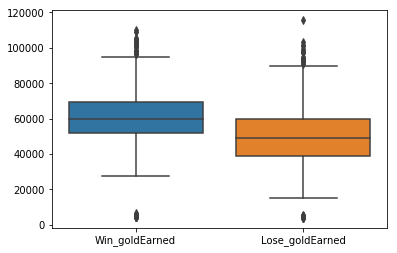

In [14]:
sns.boxplot(data=team_stats[['Win_goldEarned','Lose_goldEarned']]);

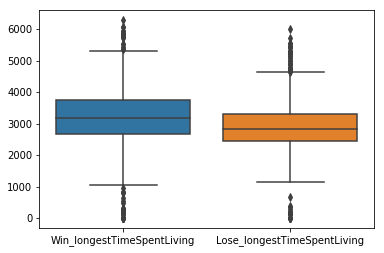

In [15]:
sns.boxplot(data=team_stats[['Win_longestTimeSpentLiving','Lose_longestTimeSpentLiving']]);

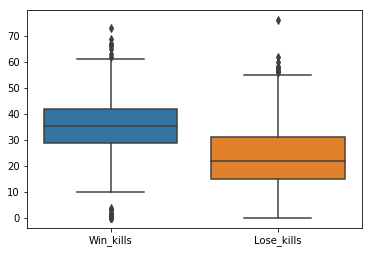

In [16]:
sns.boxplot(data=team_stats[['Win_kills','Lose_kills']]);

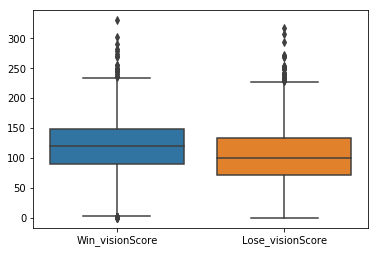

In [17]:
sns.boxplot(data=team_stats[['Win_visionScore','Lose_visionScore']]);

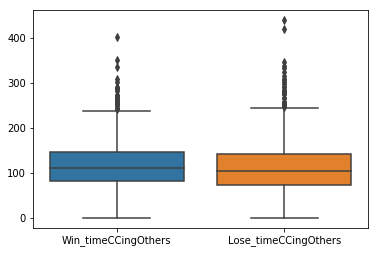

In [18]:
sns.boxplot(data=team_stats[['Win_timeCCingOthers','Lose_timeCCingOthers']]);

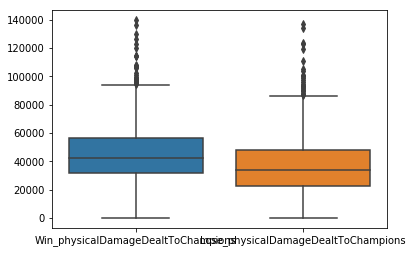

In [19]:
sns.boxplot(data=team_stats[['Win_physicalDamageDealtToChampions','Lose_physicalDamageDealtToChampions']]);

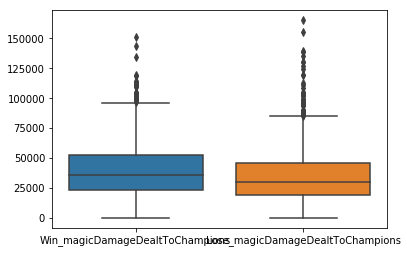

In [20]:
sns.boxplot(data=team_stats[['Win_magicDamageDealtToChampions','Lose_magicDamageDealtToChampions']]);

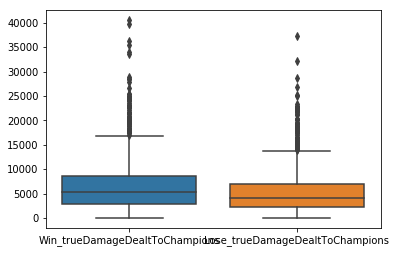

In [21]:
sns.boxplot(data=team_stats[['Win_trueDamageDealtToChampions','Lose_trueDamageDealtToChampions']]);

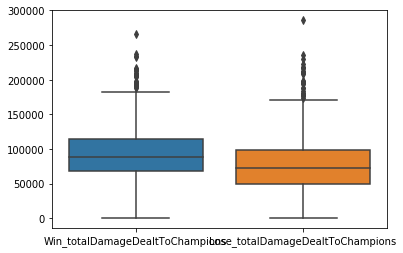

In [22]:
sns.boxplot(data=team_stats[['Win_totalDamageDealtToChampions','Lose_totalDamageDealtToChampions']]);

## Everything looks fairly even...except...

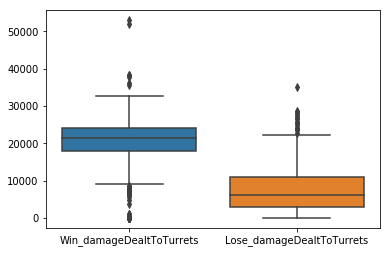

In [23]:
sns.boxplot(data=team_stats[['Win_damageDealtToTurrets','Lose_damageDealtToTurrets']]);

It would appear that teams that win tend to be those that do much more Turret Damage, or at least much more compared to the losing team. This makes sense due to the fact that the goal of each game is to destroy the enemy nexus. The only way to get closer to the nexus is by destorying the turrets that are along the way. While getting kills, gold, vision, dragons etc... are absolutely helpful, they are secondary objectives, and technically not mandatory for getting closer to the nexus, while destroying turrets is indeed essential.   

I created a correlation heatmap that shows the Pearson's correlation coefficient to compare the winning team's stats to see if perhaps there are other specific stats that strongly correlate with turret damage. We can see in the last row of the map that number of kills and gold earned are the strongest correlators. 



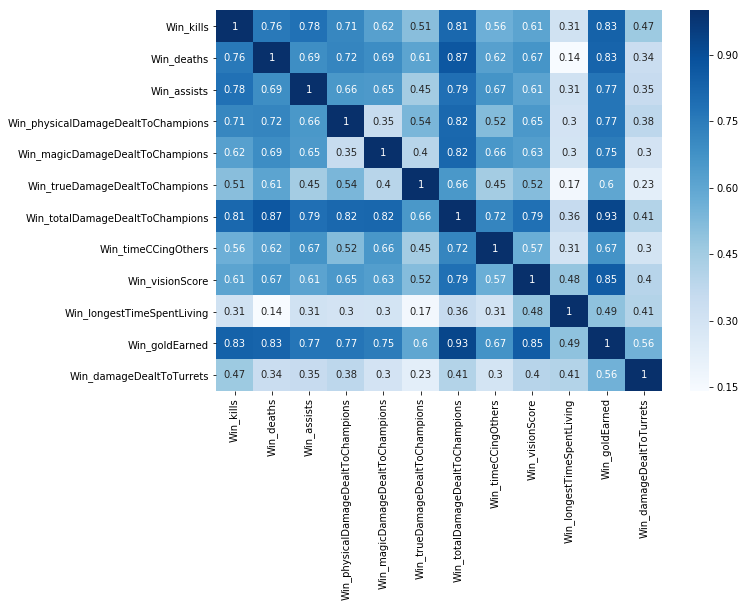

In [24]:
# Correlation heatmap (Pearson's)

winners = team_stats[[col for col in team_stats.columns if 'Win' in col]]

plt.figure(figsize=(10, 7))
sns.heatmap(winners.corr(), annot=True, cmap='Blues');              

In [25]:
# Getting Spearman correlation p-values

for feature in winners.columns:
    coef, pval = sp.stats.spearmanr(winners['Win_damageDealtToTurrets'], winners[feature])
    print(f"Spearman rank coefficient, p-value b/t Win_Turret Damage and {feature}: " + str(round(coef,3)) +
                                                                              ', ' + str(round(pval,3)))

Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_kills: 0.292, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_deaths: 0.249, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_assists: 0.203, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_physicalDamageDealtToChampions: 0.293, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_magicDamageDealtToChampions: 0.233, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_trueDamageDealtToChampions: 0.229, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_totalDamageDealtToChampions: 0.303, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_timeCCingOthers: 0.185, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_visionScore: 0.285, 0.0
Spearman rank coefficient, p-value b/t Win_Turret Damage and Win_longestTimeSpentLiving: 0.217, 0.0
Spearman rank coefficient, p-value b/t Win_T

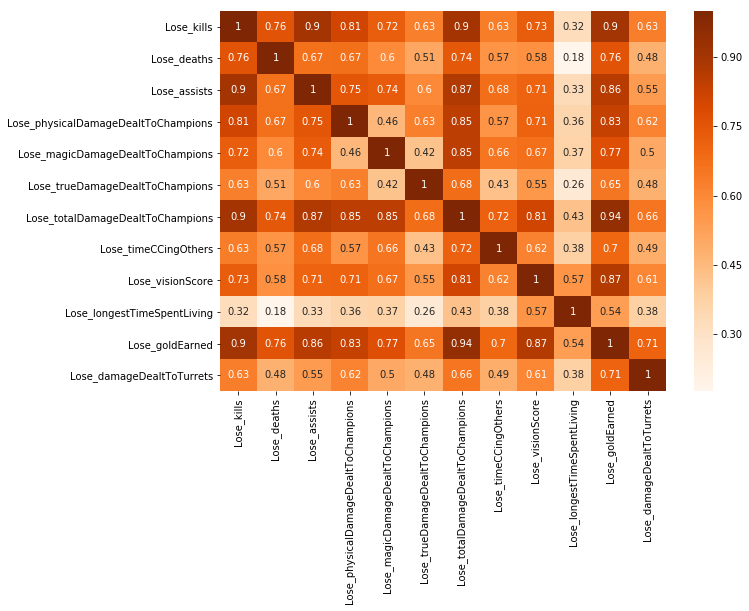

In [26]:
losers = team_stats[[col for col in team_stats.columns if 'Lose' in col]]

plt.figure(figsize=(10, 7))
sns.heatmap(losers.corr(), annot=True, cmap='Oranges');  

In [27]:
# Extracting the champID columns

champ_indexes = [col for col in df_stats.columns if 'championId' in col]  

champ_columns = df_stats[champ_indexes].reset_index(drop=True)
champ_columns.head()

,WP1_championId,WP2_championId,WP3_championId,WP4_championId,WP5_championId,LP1_championId,LP2_championId,LP3_championId,LP4_championId,LP5_championId
0,120,236,157,44,68,14,18,59,412,1
1,203,29,99,31,38,57,222,92,120,101
2,143,23,104,18,518,145,17,4,45,141
3,81,163,41,11,555,98,78,412,38,18
4,10,157,36,80,81,38,164,45,114,145


The Riot API is formatted such that champion IDs, rune IDs, and item IDs
are framed as integers. By accessing other Riot API endpoints, I was able to access the JSON files that associated their integers to their names.

In [28]:
url_champ = 'http://ddragon.leagueoflegends.com/cdn/8.24.1/data/en_US/champion.json'
champion_info = requests.get(url_champ).json()

url_rune = 'http://ddragon.leagueoflegends.com/cdn/8.24.1/data/en_US/runesReforged.json'
rune_info = requests.get(url_rune).json()

url_items = 'http://ddragon.leagueoflegends.com/cdn/8.24.1/data/en_US/item.json'
items_info = requests.get(url_items).json()

As an example, we can see below that the champion, Aatrox, is framed under the integer, 266. The key-value pairs we care about are such where keys = 'id' and 'name'.

In [29]:
champion_info['data']['Aatrox']

{'version': '8.24.1',
 'id': 'Aatrox',
 'key': '266',
 'name': 'Aatrox',
 'title': 'the Darkin Blade',
 'blurb': 'Once honored defenders of Shurima against the Void, Aatrox and his brethren would eventually become an even greater threat to Runeterra, and were defeated only by cunning mortal sorcery. But after centuries of imprisonment, Aatrox was the first to find...',
 'info': {'attack': 8, 'defense': 4, 'magic': 3, 'difficulty': 4},
 'image': {'full': 'Aatrox.png',
  'sprite': 'champion0.png',
  'group': 'champion',
  'x': 0,
  'y': 0,
  'w': 48,
  'h': 48},
 'tags': ['Fighter', 'Tank'],
 'partype': 'Blood Well',
 'stats': {'hp': 580,
  'hpperlevel': 80,
  'mp': 0,
  'mpperlevel': 0,
  'movespeed': 345,
  'armor': 33,
  'armorperlevel': 3.25,
  'spellblock': 32.1,
  'spellblockperlevel': 1.25,
  'attackrange': 175,
  'hpregen': 5,
  'hpregenperlevel': 0.25,
  'mpregen': 0,
  'mpregenperlevel': 0,
  'crit': 0,
  'critperlevel': 0,
  'attackdamage': 60,
  'attackdamageperlevel': 5,
  '

In [30]:
# key_to_champ: Dictionary with the championID as keys and champion name as values  

champ_list = list(champion_info['data'].keys())

champ_keys = []
for champ in champ_list:
    key = champion_info['data'][champ]['key']
    champ_keys.append(int(key))

champ_to_key = dict(zip(champ_list, champ_keys))
key_to_champ = dict(zip(champ_keys,champ_list))

list(champ_to_key.items())[:10] #The first ten pairs of the dictionary

[('Aatrox', 266),
 ('Ahri', 103),
 ('Akali', 84),
 ('Alistar', 12),
 ('Amumu', 32),
 ('Anivia', 34),
 ('Annie', 1),
 ('Ashe', 22),
 ('AurelionSol', 136),
 ('Azir', 268)]

In [31]:
champ_to_key['Ziggs']

115

In [32]:
# key_to_rune: Dictionary with the RuneID as keys and rune name as values

rune_to_key = {}
key_to_rune = {}

for rune_path in rune_info:
    for rune_line in rune_path['slots']:
        for rune in rune_line['runes']:
            rune_to_key[rune['key']] = rune['id']
            key_to_rune[rune['id']] = rune['key']
            
list(rune_to_key.items())[:10] #The first ten pairs of the dictionary

[('Electrocute', 8112),
 ('Predator', 8124),
 ('DarkHarvest', 8128),
 ('HailOfBlades', 9923),
 ('CheapShot', 8126),
 ('TasteOfBlood', 8139),
 ('SuddenImpact', 8143),
 ('ZombieWard', 8136),
 ('GhostPoro', 8120),
 ('EyeballCollection', 8138)]

In [33]:
#Generate a sample of games that Does have Tristana
turrets = ['Win_damageDealtToTurrets','Lose_damageDealtToTurrets','TurretDamageDiff']

trist_index = []
trist_wins = 0
win_check = 5
for index, row in champ_columns.iterrows():
    for position, key in enumerate(row):
        if key == champ_to_key['Tristana']:
            trist_index.append(index)
            if position < win_check:
                trist_wins += 1 # We know the winners are represented by the first 5 columns
            break 

trist_games = team_stats[turrets].reset_index(drop=True).iloc[trist_index,:]
trist_games = trist_games[~np.all(trist_games == 0, axis=1)]
print("Tristana's winrate is",trist_wins/trist_games.shape[0])
trist_games.head()

Tristana's winrate is 0.4674329501915709


,Win_damageDealtToTurrets,Lose_damageDealtToTurrets,TurretDamageDiff
0,18539.0,10957.0,7582.0
2,27157.0,28543.0,-1386.0
3,22013.0,17478.0,4535.0
5,26606.0,9818.0,16788.0
8,27479.0,10277.0,17202.0


In [34]:
#Generate a sample of games that does NOT have Tristana

all_game_indexes = list(df_stats.reset_index(drop=True).index.values)
notrist_index = list(set(all_game_indexes) - set(trist_index))
notrist_games = team_stats[turrets].reset_index(drop=True).iloc[notrist_index,:]

notrist_games = notrist_games[~np.all(notrist_games == 0, axis=1)]
notrist_games.head()

,Win_damageDealtToTurrets,Lose_damageDealtToTurrets,TurretDamageDiff
1,3761.0,0.0,3761.0
4,17840.0,3298.0,14542.0
6,14133.0,15973.0,-1840.0
7,26834.0,3344.0,23490.0
9,16259.0,2130.0,14129.0


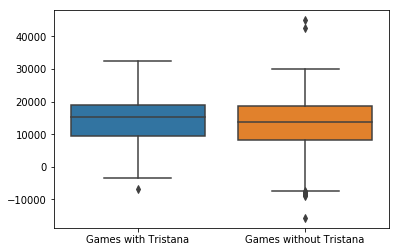

In [35]:
# Boxplot showing Turret Damage difference between winning/losing teams
# Left plot consists of games WITH Tristana, while right plot does NOT

sns.boxplot(data=[trist_games['TurretDamageDiff'], notrist_games['TurretDamageDiff']]);
plt.xticks([0,1,],['Games with Tristana','Games without Tristana']);

In [36]:
#Prepping for t-test

trist = trist_games['TurretDamageDiff']
notrist = notrist_games['TurretDamageDiff']

mean_trist = np.mean(trist)
mean_notrist = np.mean(notrist)

mean_diff = mean_trist - mean_notrist

sp.stats.ttest_ind(trist, notrist)

Ttest_indResult(statistic=2.0329970682180223, pvalue=0.04226773095347995)

In [37]:
#pvalue = 0.042...Interesting, what about all other champions?

#Generate a sample of games that Does have THE CHAMPION
turrets = ['Win_damageDealtToTurrets','Lose_damageDealtToTurrets','TurretDamageDiff']

champ_indexes = [col for col in df_stats.columns if 'championId' in col]  
champ_columns = df_stats[champ_indexes].reset_index(drop=True)

def champ_stats(name):
    '''Input a LoL champion to output the stats regarding turret damage
    win proportion, and p-values determining statistical significance of
    turret damage'''

    champ_index = []
    champ_wins = 0 # Initialize count
    win_check = 5 # We know the first five rows refer to the winning players 
    for index, row in champ_columns.iterrows():
        for position, key in enumerate(row):
            if key == champ_to_key[name]:
                champ_index.append(index)
                if position < win_check:
                    champ_wins += 1
                break 

    games_with = team_stats[turrets].reset_index(drop=True).iloc[champ_index,:]
    games_with = games_with[~np.all(games_with == 0, axis=1)] # Removes rows where all values equal 0 

    #Generate a random sample of games that does NOT have THE CHAMPION

    all_game_indexes = list(df_stats.reset_index(drop=True).index.values)
    nochamp_index = list(set(all_game_indexes) - set(champ_index))

    nogames_with = team_stats[turrets].reset_index(drop=True).iloc[nochamp_index,:]
    nogames_with = nogames_with[~np.all(nogames_with == 0, axis=1)]
    
    games = games_with['TurretDamageDiff']
    nogames = nogames_with['TurretDamageDiff']
    
    #sns.boxplot(data=[games, nogames]);
    #plt.xticks([0,1],[f' Turret Damage Diff in games with {name}',f'Turret Damage Diff in games without {name}']);

    #Champ's winrate
    #print (f"{name}'s winrate is", champ_wins/games_with.shape[0])
    
    #t-test results
    t_results = sp.stats.ttest_ind(games, nogames)
    p_value = list(t_results)[1]
    return (p_value)



In [38]:
turrets_pval = pd.DataFrame()
turrets_pval['Champion'] = champ_list
pvals = []
for champ in champ_list:
    pvals.append(champ_stats(champ))
turrets_pval['P-value'] = pvals
turrets_pval.head()

,Champion,P-value
0,Aatrox,0.173620
1,Ahri,0.006998
2,Akali,0.077597
3,Alistar,0.064499
4,Amumu,0.196314


In [39]:
# Collecting all the p-values and correcting them with Benjamini/Hochberg FDR 

corrected_pvals = smt.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
corrected_pvals

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [40]:
turrets_pval['Corrected P-value'] = corrected_pvals[1]

In [41]:
turrets_pval[turrets_pval['Corrected P-value'] < 0.25]

,Champion,P-value,Corrected P-value
1,Ahri,0.006998,0.244437
36,Hecarim,0.003219,0.244437
41,Janna,0.005959,0.244437
70,MasterYi,0.008519,0.244437
120,Udyr,0.010328,0.244437
135,Yorick,0.010273,0.244437


### Section 3: Machine Learning

In [42]:
# Prepping Dataframe for Logistic Regression

# The function below is essentially the same as the previous function (create_row_for_stats),
# except I took off the code that makes the first five players of the relevant team.

def create_row_for_ML(row):
    '''Unpacks each list of dictionaries, from each CLASSIC game, to create a pandas row.'''

    a_row = []   
    for players in row:
        stats_player = pd.DataFrame.from_dict(players['stats'], orient = 'index') #Turns the dict into a pandas row
        a_row.append(stats_player.T[stats_keep_columns]) #Transposes then extracts 
        champ_player = pd.DataFrame.from_dict(dict((list(players.items())[2],)), orient = 'index')
        a_row.append(champ_player.T) #Adds in the champion each player played
        the_row = pd.concat(a_row, axis = 1)

    return the_row 

    
all_games_for_ML = newclassicgames.apply(create_row_for_ML)
all_games_for_ML.head()

0      participantId   win item0 item1 item2 item3 ...
1      participantId   win item0 item1 item2 item3 ...
2      participantId   win item0 item1 item2 item3 ...
3      participantId    win item0 item1 item2 item3...
4      participantId    win item0 item1 item2 item3...
Name: participants, dtype: object

In [43]:
# Let Wins for Team A be represented by 1, and wins for Team B be represented by 0
chunks = []
for chunk in all_games_for_ML:
    if chunk.iloc[:,1].bool() == True:
        chunk['Team_win'] = 1
    else:
        chunk['Team_win'] = 0
    chunks.append(chunk)    
df_ML = pd.concat(chunks)
df_ML = df_ML.drop(['participantId','win'], axis=1)
df_ML.head()

,item0,item1,item2,item3,item4,item5,item6,kills,deaths,assists,...,goldEarned,turretKills,perk0,perk1,perk2,perk3,perk4,perk5,championId,Team_win
0,1401,3111,3078,3053,1031,1011,3364,9,5,14,...,13320,0,8229,8226,8210,8236,8138,8105,1,1
0,1412,2031,3086,3006,2015,1028,3364,6,1,5,...,5408,0,8229,8226,8233,8236,8313,8347,101,1
0,3157,1026,3020,3916,3151,3116,3364,8,9,17,...,14651,0,8112,8143,8138,8105,8234,8236,141,1
0,3748,3075,3047,3068,0,0,3363,4,2,12,...,8380,0,8112,8143,8136,8135,8275,8210,555,0
0,3020,3157,2033,3027,2055,0,3340,5,6,1,...,8340,2,8359,8304,8345,8347,8210,8226,81,0


In [44]:
# Renaming the column headers for clarity's sake

new_names = []
player_indexes = [index for index, col_name in enumerate(df_ML) if col_name == 'item0']
for player in range(5):
    if player != 0:
        wp = df_ML.iloc[:,player_indexes[player]:player_indexes[player+1]].add_prefix('TeamA_P'+str(player+1)+'_')
    else:
        wp = df_ML.iloc[:,:player_indexes[player+1]].add_prefix('TeamA_P'+str(player+1)+'_')
    new_names.append(wp)
        
for player in range(5,10):
    if player != 9:
        lp = df_ML.iloc[:,player_indexes[player]:player_indexes[player+1]].add_prefix('TeamB_P'+str(player-4)+'_')
    else:
        lp = df_ML.iloc[:,player_indexes[player]:len(list(df_ML))-1].add_prefix('TeamB_P'+str(player-4)+'_')
    new_names.append(lp)
new_names.append(df_ML.loc[:,'Team_win'])    
newdf_ML = pd.concat(new_names, axis=1)
newdf_ML.reset_index(drop=True).head()

,TeamA_P1_item0,TeamA_P1_item1,TeamA_P1_item2,TeamA_P1_item3,TeamA_P1_item4,TeamA_P1_item5,TeamA_P1_item6,TeamA_P1_kills,TeamA_P1_deaths,TeamA_P1_assists,...,TeamB_P5_goldEarned,TeamB_P5_turretKills,TeamB_P5_perk0,TeamB_P5_perk1,TeamB_P5_perk2,TeamB_P5_perk3,TeamB_P5_perk4,TeamB_P5_perk5,TeamB_P5_championId,Team_win
0,1401,3111,3078,3053,1031,1011,3364,9,5,14,...,13320,0,8229,8226,8210,8236,8138,8105,1,1
1,1412,2031,3086,3006,2015,1028,3364,6,1,5,...,5408,0,8229,8226,8233,8236,8313,8347,101,1
2,3157,1026,3020,3916,3151,3116,3364,8,9,17,...,14651,0,8112,8143,8138,8105,8234,8236,141,1
3,3748,3075,3047,3068,0,0,3363,4,2,12,...,8380,0,8112,8143,8136,8135,8275,8210,555,0
4,3020,3157,2033,3027,2055,0,3340,5,6,1,...,8340,2,8359,8304,8345,8347,8210,8226,81,0


In [45]:
item_keys = list(items_info['data'].keys())
item_list = []
for key in item_keys:
    item = items_info['data'][key]['name']
    item_list.append(item)

item_keys = list(map(int, item_keys))

key_to_item = dict(zip(item_keys,item_list))
item_to_key = dict(zip(item_list,item_keys))

list(key_to_item.items())[:10] #The 'head' of the dictionary

[(1001, 'Boots of Speed'),
 (1004, 'Faerie Charm'),
 (1006, 'Rejuvenation Bead'),
 (1011, "Giant's Belt"),
 (1026, 'Blasting Wand'),
 (1027, 'Sapphire Crystal'),
 (1028, 'Ruby Crystal'),
 (1029, 'Cloth Armor'),
 (1031, 'Chain Vest'),
 (1033, 'Null-Magic Mantle')]

In [46]:
# Converting the champ keys into champion name to give appropriate category name

championIDs = [col for col in newdf_ML.columns if 'championId' in col]
itemIDs = [col for col in newdf_ML.columns if 'item' in col]
runeIDs = [col for col in newdf_ML.columns if 'perk' in col]


for col in championIDs:
    newdf_ML[col] = newdf_ML[col].replace(key_to_champ)

for col in itemIDs:
    newdf_ML[col] = newdf_ML[col].replace(key_to_item)

for col in runeIDs:
    newdf_ML[col] = newdf_ML[col].replace(key_to_rune)

newdf_ML = newdf_ML.reset_index(drop=True)
newdf_ML.head()

,TeamA_P1_item0,TeamA_P1_item1,TeamA_P1_item2,TeamA_P1_item3,TeamA_P1_item4,TeamA_P1_item5,TeamA_P1_item6,TeamA_P1_kills,TeamA_P1_deaths,TeamA_P1_assists,...,TeamB_P5_goldEarned,TeamB_P5_turretKills,TeamB_P5_perk0,TeamB_P5_perk1,TeamB_P5_perk2,TeamB_P5_perk3,TeamB_P5_perk4,TeamB_P5_perk5,TeamB_P5_championId,Team_win
0,Enchantment: Cinderhulk,Mercury's Treads,Trinity Force,Sterak's Gage,Chain Vest,Giant's Belt,Oracle Lens,9,5,14,...,13320,0,ArcaneComet,ManaflowBand,Transcendence,GatheringStorm,EyeballCollection,RelentlessHunter,Annie,1
1,Enchantment: Warrior,Refillable Potion,Zeal,Berserker's Greaves,Kircheis Shard,Ruby Crystal,Oracle Lens,6,1,5,...,5408,0,ArcaneComet,ManaflowBand,AbsoluteFocus,GatheringStorm,PerfectTiming,CosmicInsight,Xerath,1
2,Zhonya's Hourglass,Blasting Wand,Sorcerer's Shoes,Oblivion Orb,Liandry's Torment,Rylai's Crystal Scepter,Oracle Lens,8,9,17,...,14651,0,Electrocute,SuddenImpact,EyeballCollection,RelentlessHunter,Celerity,GatheringStorm,Kayn,1
3,Titanic Hydra,Thornmail,Ninja Tabi,Sunfire Cape,0,0,Farsight Alteration,4,2,12,...,8380,0,Electrocute,SuddenImpact,ZombieWard,RavenousHunter,NimbusCloak,Transcendence,Pyke,0
4,Sorcerer's Shoes,Zhonya's Hourglass,Corrupting Potion,Rod of Ages,Control Ward,0,Warding Totem (Trinket),5,6,1,...,8340,2,Kleptomancy,MagicalFootwear,BiscuitDelivery,CosmicInsight,Transcendence,ManaflowBand,Ezreal,0


In [47]:
# TEAM DATA

agg = ['kills', 'deaths', 'assists', 'physicalDamageDealtToChampions', 'magicDamageDealtToChampions',
       'trueDamageDealtToChampions','totalDamageDealtToChampions', 'timeCCingOthers', 'visionScore',
       'longestTimeSpentLiving', 'goldEarned', 'damageDealtToTurrets']

team_ML = pd.DataFrame()

for feature in agg: 
    team_ML['TeamA_'+ feature] = newdf_ML[[col for col in newdf_ML.columns if 'TeamA' in col 
                                           and feature in col]].sum(axis=1)
    team_ML['TeamB_'+ feature] = newdf_ML[[col for col in newdf_ML.columns if 'TeamB' in col 
                                           and feature in col]].sum(axis=1)
team_ML['TurretDamageDiff'] = team_ML['TeamA_damageDealtToTurrets'] - team_ML['TeamB_damageDealtToTurrets']
team_ML.reset_index(drop=True).head()

,TeamA_kills,TeamB_kills,TeamA_deaths,TeamB_deaths,TeamA_assists,TeamB_assists,TeamA_physicalDamageDealtToChampions,TeamB_physicalDamageDealtToChampions,TeamA_magicDamageDealtToChampions,TeamB_magicDamageDealtToChampions,...,TeamB_timeCCingOthers,TeamA_visionScore,TeamB_visionScore,TeamA_longestTimeSpentLiving,TeamB_longestTimeSpentLiving,TeamA_goldEarned,TeamB_goldEarned,TeamA_damageDealtToTurrets,TeamB_damageDealtToTurrets,TurretDamageDiff
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,175.0,136.0,132.0,2881.0,3508.0,68627.0,57459.0,18539.0,10957.0,7582.0
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,63.0,42.0,54.0,1561.0,2556.0,29260.0,24569.0,3761.0,0.0,3761.0
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,134.0,127.0,134.0,2658.0,2397.0,80414.0,77352.0,27157.0,28543.0,-1386.0
3,35.0,15.0,15.0,36.0,60.0,13.0,36048.0,40746.0,36046.0,30297.0,...,84.0,141.0,94.0,5477.0,2321.0,63015.0,57032.0,17478.0,22013.0,-4535.0
4,13.0,26.0,26.0,13.0,17.0,21.0,16206.0,30744.0,19702.0,17770.0,...,66.0,64.0,81.0,2717.0,2684.0,32181.0,41397.0,3298.0,17840.0,-14542.0


In [52]:
# Inputting item counts for each game

for item in item_list:
    team_ML['TeamA_'+ item] = 0
    team_ML['TeamB_'+ item] = 0

item_columns_TeamA = [col for col in newdf_ML.columns if 'item' in col and 'TeamA' in col]
item_columns_TeamB = [col for col in newdf_ML.columns if 'item' in col and 'TeamB' in col]
items_ML_TeamA = newdf_ML[item_columns_TeamA]
items_ML_TeamB = newdf_ML[item_columns_TeamB]

for game_index in range(0,team_ML.shape[0]):
    item_count_TeamA = collections.Counter((items_ML_TeamA.loc[game_index].tolist()))
    item_count_TeamB = collections.Counter((items_ML_TeamB.loc[game_index].tolist()))
    for item, count in list(item_count_TeamA.items()):
        if isinstance(item, str) == True:
            team_ML.loc[game_index,'TeamA_'+ item] = count
    for item, count in list(item_count_TeamB.items()):
        if isinstance(item, str) == True:
            team_ML.loc[game_index,'TeamB_'+ item] = count
team_ML.head()

,TeamA_kills,TeamB_kills,TeamA_deaths,TeamB_deaths,TeamA_assists,TeamB_assists,TeamA_physicalDamageDealtToChampions,TeamB_physicalDamageDealtToChampions,TeamA_magicDamageDealtToChampions,TeamB_magicDamageDealtToChampions,...,TeamA_Philosopher's Medallion,TeamB_Philosopher's Medallion,TeamA_Heart of Targon,TeamB_Heart of Targon,TeamA_Force of Nature,TeamB_Force of Nature,TeamA_Innervating Locket,TeamB_Innervating Locket,TeamA_Stat-Stick of Stoicism,TeamB_Stat-Stick of Stoicism
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,0,0,0,0,0,0,0,0,0,0
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,0,0,0,0,0,0,0,0,0,0
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,0,0,0,0,0,0,0,0,0,0
3,35.0,15.0,15.0,36.0,60.0,13.0,36048.0,40746.0,36046.0,30297.0,...,0,0,0,0,0,0,0,0,0,0
4,13.0,26.0,26.0,13.0,17.0,21.0,16206.0,30744.0,19702.0,17770.0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# Inputting rune counts for each game

rune_list = list(rune_to_key.keys())

for rune in rune_list:
    team_ML['TeamA_'+ rune] = 0
    team_ML['TeamB_'+ rune] = 0

rune_columns_TeamA = [col for col in newdf_ML.columns if 'perk' in col and 'TeamA' in col]
rune_columns_TeamB = [col for col in newdf_ML.columns if 'perk' in col and 'TeamB' in col]
rune_ML_TeamA = newdf_ML[rune_columns_TeamA]
rune_ML_TeamB = newdf_ML[rune_columns_TeamB]

for game_index in range(0,team_ML.shape[0]):
    rune_count_TeamA = collections.Counter(rune_ML_TeamA.loc[game_index].tolist())
    rune_count_TeamB = collections.Counter(rune_ML_TeamB.loc[game_index].tolist())
    for rune, count in list(rune_count_TeamA.items()):
        if isinstance(rune, str) == True:
            team_ML.loc[game_index,'TeamA_'+ rune] = count
    for rune, count in list(rune_count_TeamB.items()):
        if isinstance(rune, str) == True:
            team_ML.loc[game_index,'TeamB_'+ rune] = count
team_ML.head()


,TeamA_kills,TeamB_kills,TeamA_deaths,TeamB_deaths,TeamA_assists,TeamB_assists,TeamA_physicalDamageDealtToChampions,TeamB_physicalDamageDealtToChampions,TeamA_magicDamageDealtToChampions,TeamB_magicDamageDealtToChampions,...,TeamA_Celerity,TeamB_Celerity,TeamA_AbsoluteFocus,TeamB_AbsoluteFocus,TeamA_Scorch,TeamB_Scorch,TeamA_Waterwalking,TeamB_Waterwalking,TeamA_GatheringStorm,TeamB_GatheringStorm
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,0,1,2,1,1,0,0,0,1,3
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,0,1,2,1,0,1,1,1,1,1
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,0,3,1,1,2,1,0,1,1,3
3,35.0,15.0,15.0,36.0,60.0,13.0,36048.0,40746.0,36046.0,30297.0,...,1,1,0,0,0,1,0,0,1,1
4,13.0,26.0,26.0,13.0,17.0,21.0,16206.0,30744.0,19702.0,17770.0,...,1,0,1,1,1,1,1,0,2,1


In [54]:
# Inputting champ counts for each game

for champ in champ_list:
    team_ML['TeamA_'+ champ] = 0
    team_ML['TeamB_'+ champ] = 0

champ_columns_TeamA = [col for col in newdf_ML.columns if 'championId' in col and 'TeamA' in col]
champ_columns_TeamB = [col for col in newdf_ML.columns if 'championId' in col and 'TeamB' in col]
champ_ML_TeamA = newdf_ML[champ_columns_TeamA]
champ_ML_TeamB = newdf_ML[champ_columns_TeamB]


for game_index in range(0,team_ML.shape[0]):
    champ_count_TeamA = collections.Counter(champ_ML_TeamA.loc[game_index].tolist())
    champ_count_TeamB = collections.Counter(champ_ML_TeamB.loc[game_index].tolist())
    for champ, count in list(champ_count_TeamA.items()):
        if isinstance(champ, str) == True:
            team_ML.loc[game_index,'TeamA_'+ champ] = count
    for champ, count in list(rune_count_TeamB.items()):
        if isinstance(champ, str) == True:
            team_ML.loc[game_index,'TeamB_'+ champ] = count
team_ML.head()

,TeamA_kills,TeamB_kills,TeamA_deaths,TeamB_deaths,TeamA_assists,TeamB_assists,TeamA_physicalDamageDealtToChampions,TeamB_physicalDamageDealtToChampions,TeamA_magicDamageDealtToChampions,TeamB_magicDamageDealtToChampions,...,TeamA_Zed,TeamB_Zed,TeamA_Ziggs,TeamB_Ziggs,TeamA_Zilean,TeamB_Zilean,TeamA_Zoe,TeamB_Zoe,TeamA_Zyra,TeamB_Zyra
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,0,0,0,0,0,0,0,0,0,0
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,0,0,0,0,0,0,0,0,0,0
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,0,0,0,0,0,0,0,0,1,0
3,35.0,15.0,15.0,36.0,60.0,13.0,36048.0,40746.0,36046.0,30297.0,...,0,0,0,0,0,0,0,0,0,0
4,13.0,26.0,26.0,13.0,17.0,21.0,16206.0,30744.0,19702.0,17770.0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
team_ML['Team_win'] = newdf_ML['Team_win']
team_ML.head()

,TeamA_kills,TeamB_kills,TeamA_deaths,TeamB_deaths,TeamA_assists,TeamB_assists,TeamA_physicalDamageDealtToChampions,TeamB_physicalDamageDealtToChampions,TeamA_magicDamageDealtToChampions,TeamB_magicDamageDealtToChampions,...,TeamB_Zed,TeamA_Ziggs,TeamB_Ziggs,TeamA_Zilean,TeamB_Zilean,TeamA_Zoe,TeamB_Zoe,TeamA_Zyra,TeamB_Zyra,Team_win
0,42.0,31.0,31.0,42.0,74.0,54.0,53489.0,44268.0,64889.0,52657.0,...,0,0,0,0,0,0,0,0,0,1
1,14.0,7.0,7.0,14.0,16.0,7.0,16550.0,11423.0,16198.0,11357.0,...,0,0,0,0,0,0,0,0,0,1
2,55.0,51.0,51.0,56.0,50.0,52.0,68588.0,39163.0,69597.0,90051.0,...,0,0,0,0,0,0,0,1,0,1
3,35.0,15.0,15.0,36.0,60.0,13.0,36048.0,40746.0,36046.0,30297.0,...,0,0,0,0,0,0,0,0,0,0
4,13.0,26.0,26.0,13.0,17.0,21.0,16206.0,30744.0,19702.0,17770.0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
X = team_ML.drop('Team_win',axis = 1)
y = team_ML['Team_win']

In [57]:
# Begin tuning our first model

c_space = np.logspace(-10, 8, 20)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 6.951927961775605e-08, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.9809045226130654


In [58]:
# Is it worth scaling, given the wide ranges of data?

steps = [('scaler', StandardScaler()),
        ('logreg', LogisticRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training set: knn_scaled
logreg_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a LR classifier to the unscaled data
logreg_unscaled = LogisticRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(logreg_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(logreg_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.9357429718875502
Accuracy without Scaling: 0.9879518072289156
